In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DDPG, TD3, SAC
from sb3_contrib import TQC as D4PG
import torch
import pandas as pd
import os
from stable_baselines3.common.callbacks import BaseCallback
from torch import nn

# Set random seed
RANDOM_SEED = 42

# Directory to save models and data
SAVE_DIR = "Output"
os.makedirs(SAVE_DIR, exist_ok=True)

def select_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ContinuousToDiscreteWrapper(gym.ActionWrapper):
    """
    Custom wrapper to convert continuous actions to discrete actions.
    """
    def __init__(self, env):
        super(ContinuousToDiscreteWrapper, self).__init__(env)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

    def action(self, action):
        # Convert continuous action to discrete action (0 or 1)
        return 0 if action < 0 else 1

class RewardCallback(BaseCallback):
    """
    Custom callback for saving episode rewards.
    """
    def __init__(self):
        super(RewardCallback, self).__init__()
        self.episode_rewards = []
        self.episode_reward = 0
        self.episode_count = 0

    def _on_step(self) -> bool:
        self.episode_reward += self.locals.get("rewards", 0)
        if self.locals.get("dones"):
            self.episode_rewards.append(self.episode_reward)
            self.episode_reward = 0
            self.episode_count += 1
        return True

def train_and_evaluate(model_class, env, timesteps=100000, model_name="model"): 
    """
    Train a model using the specified RL algorithm and evaluate its rewards.
    """
    policy_kwargs = dict(net_arch=[256, 256], activation_fn=nn.ReLU)
    model = model_class("MlpPolicy", env, verbose=1, seed=RANDOM_SEED, device=select_device(), policy_kwargs=policy_kwargs)
    callback = RewardCallback()
    model.learn(total_timesteps=timesteps, callback=callback)
    model.save(os.path.join(SAVE_DIR, model_name))  # Save the model after training
    return callback.episode_rewards

def save_training_data(all_rewards):
    """
    Save rewards data for each model in a DataFrame and save as pkl.
    """
    rewards_df = pd.DataFrame(dict([(algo_name, pd.Series(rewards)) for algo_name, rewards in all_rewards.items()]))
    rewards_df.to_pickle(os.path.join(SAVE_DIR, "training_rewards.pkl"))
    print("Training data saved to training_rewards.pkl")

def save_average_rewards(all_rewards):
    """
    Save average rewards data for each model in a DataFrame and save as pkl.
    """
    avg_rewards_df = pd.DataFrame({algo_name: pd.Series(rewards).expanding().mean() for algo_name, rewards in all_rewards.items()})
    avg_rewards_df.to_pickle(os.path.join(SAVE_DIR, "average_rewards.pkl"))
    print("Average rewards data saved to average_rewards.pkl")

def plot_saved_data(pkl_file):
    """
    Plot rewards from saved pkl file.
    """
    rewards_df = pd.read_pickle(pkl_file)
    rewards_df = rewards_df.dropna(how='all', axis=1)

    if rewards_df.empty:
        print("No rewards data to plot.")
        return

    # Plot each algorithm separately
    for column in rewards_df.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(rewards_df.index, rewards_df[column], label=column)
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.ylim((0, 550))
        plt.title(f"Training Rewards for {column} on CartPole-v1")
        plt.legend()
        plt.grid()
        plt.show()

def plot_average_rewards(pkl_file):
    """
    Plot average rewards from saved pkl file.
    """
    avg_rewards_df = pd.read_pickle(pkl_file)
    avg_rewards_df = avg_rewards_df.dropna(how='all', axis=1)

    if avg_rewards_df.empty:
        print("No average rewards data to plot.")
        return

    # Plot each algorithm separately
    for column in avg_rewards_df.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(avg_rewards_df.index, avg_rewards_df[column], label=column)
        plt.xlabel("Episodes")
        plt.ylabel("Average Reward")
        plt.title(f"Average Rewards per Episode for {column} on CartPole-v1")
        plt.legend()
        plt.grid()
        plt.show()

def render_saved_model(model_path, env_name):
    """
    Load a saved model and render the environment.
    """
    env = gym.make(env_name, render_mode="human")
    env = ContinuousToDiscreteWrapper(env)
    model = SAC.load(model_path)  # Example: Load a saved SAC model
    obs, info = env.reset()
    done, truncated = False, False
    while not (done or truncated):
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
    env.close()

def main():
    # Set up environment and seed
    env_name = "CartPole-v1"
    env = gym.make(env_name)
    env = ContinuousToDiscreteWrapper(env)  # Wrap the environment to convert continuous actions to discrete
    env.action_space.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    # Algorithms to evaluate
    algorithms = {
        "DDPG": DDPG,
        "TD3": TD3,
        "SAC": SAC,
        "D4PG": D4PG
    }

    # Train and collect rewards for each algorithm
    all_rewards = {}
    timesteps = 10000
    for algo_name, algo_class in algorithms.items():
        print(f"Training {algo_name}...")
        model_name = f"{algo_name}_cartpole"
        all_rewards[algo_name] = train_and_evaluate(algo_class, env, timesteps, model_name=model_name)
    
    # Save training data
    save_training_data(all_rewards)
    save_average_rewards(all_rewards)
    
    # Plot saved data
    plot_saved_data(os.path.join(SAVE_DIR, "training_rewards.pkl"))
    plot_average_rewards(os.path.join(SAVE_DIR, "average_rewards.pkl"))
    
    # Render one of the saved models
    render_saved_model(os.path.join(SAVE_DIR, "SAC_cartpole.zip"), env_name)

2024-12-06 21:53:28.575276: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 21:53:28.679589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733547208.720821    7578 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733547208.733830    7578 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 21:53:28.836484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2024-12-06 17:38:35.809639: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 17:38:35.818097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733531915.827731   71931 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733531915.830655   71931 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 17:38:35.842516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Training DDPG...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 20       |
| time/              |          |
|    episodes        | 4        |
|    fps             | 9511     |
|    time_elapsed    | 0        |
|    total_timesteps | 80       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.2     |
|    ep_rew_mean     | 22.2     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 432      |
|    time_elapsed    | 0        |
|    total_timesteps | 178      |
| train/             |          |
|    actor_loss      | -1.28    |
|    critic_loss     | 0.00462  |
|    learning_rate   | 0.001    |
|    n_updates       | 77       |
---------------------------------
---------------------------------
| ro

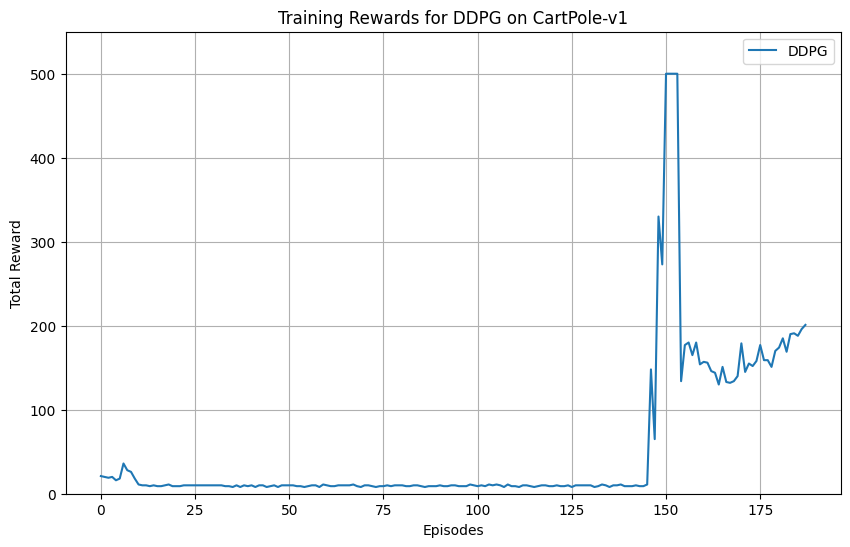

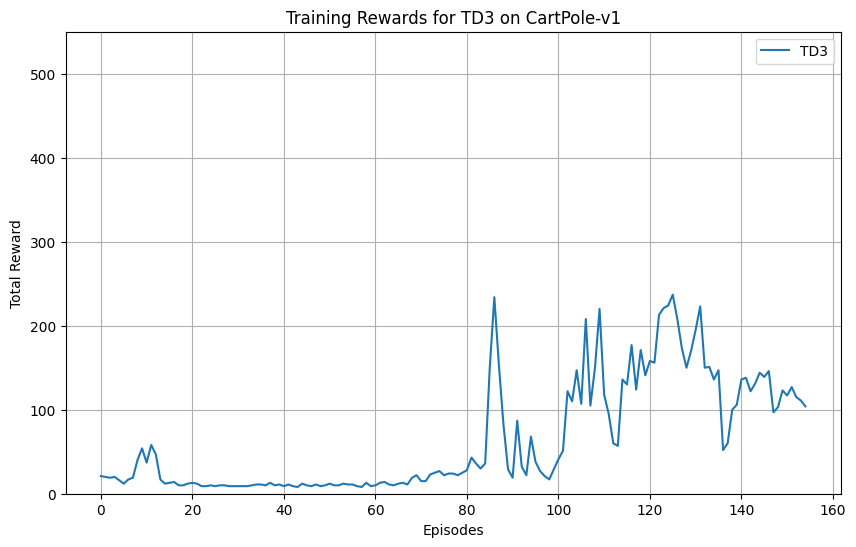

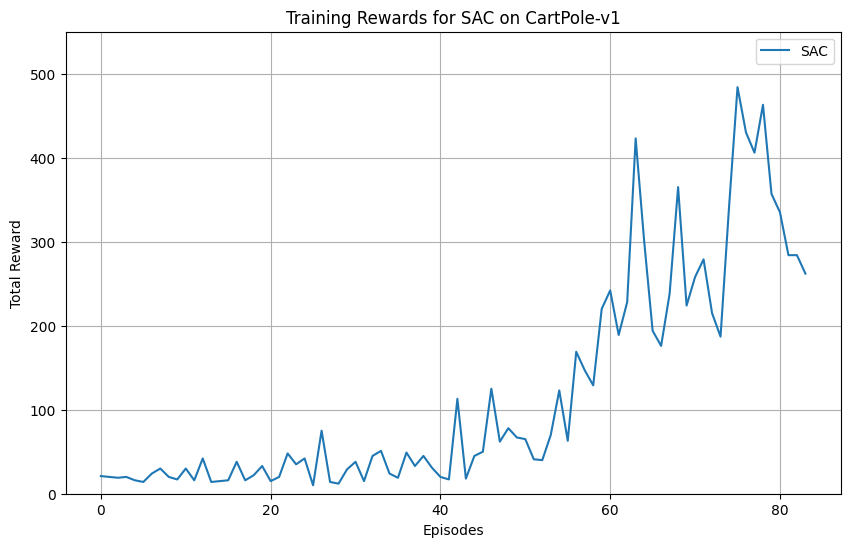

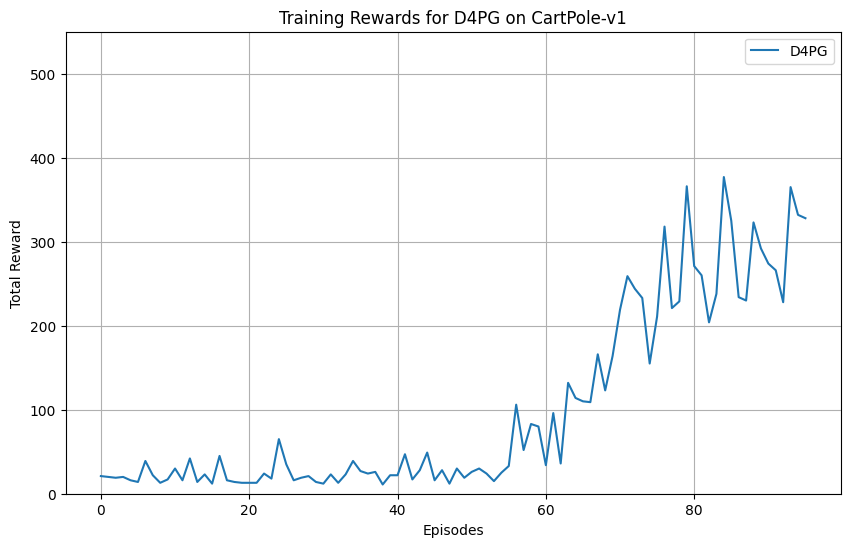

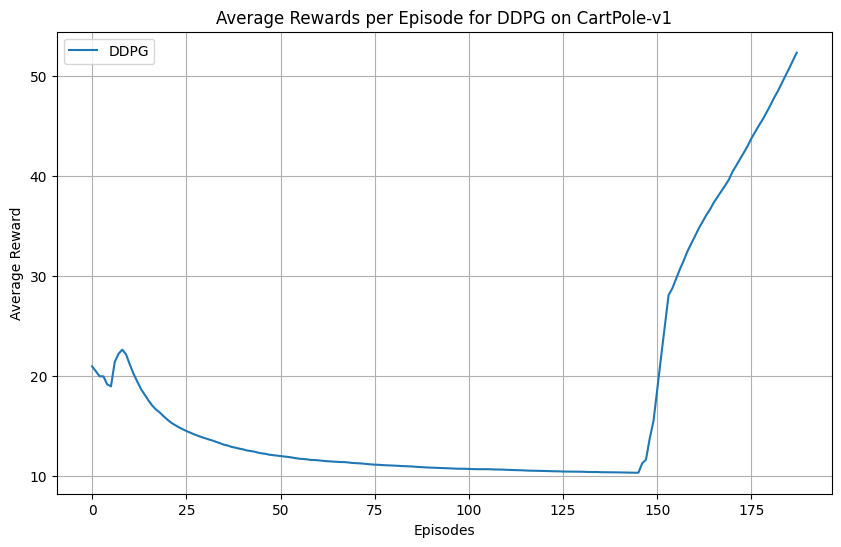

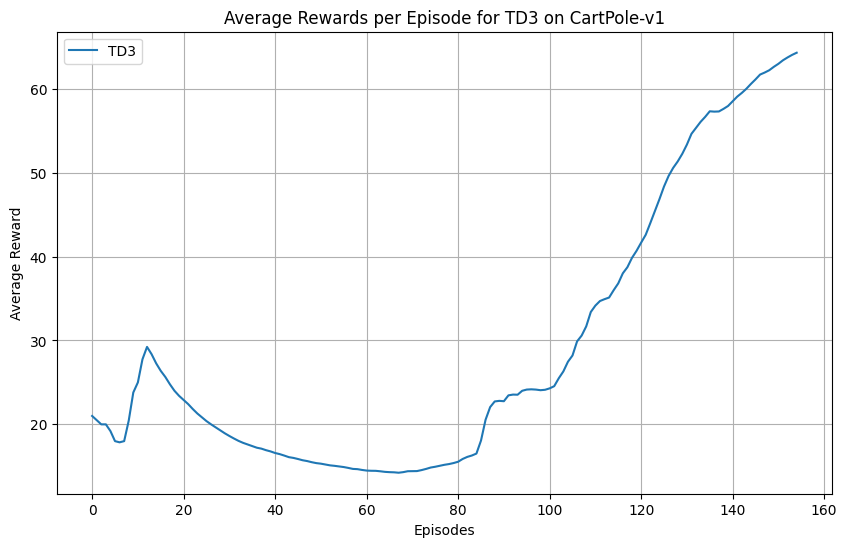

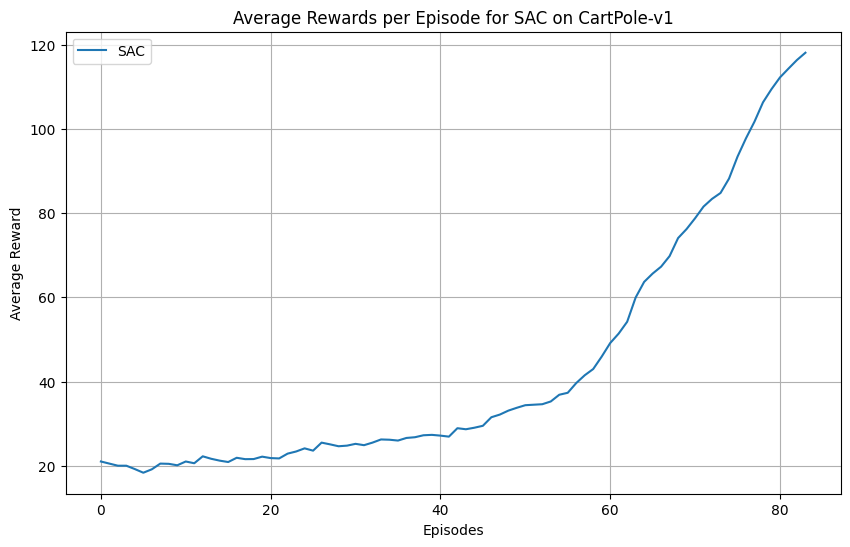

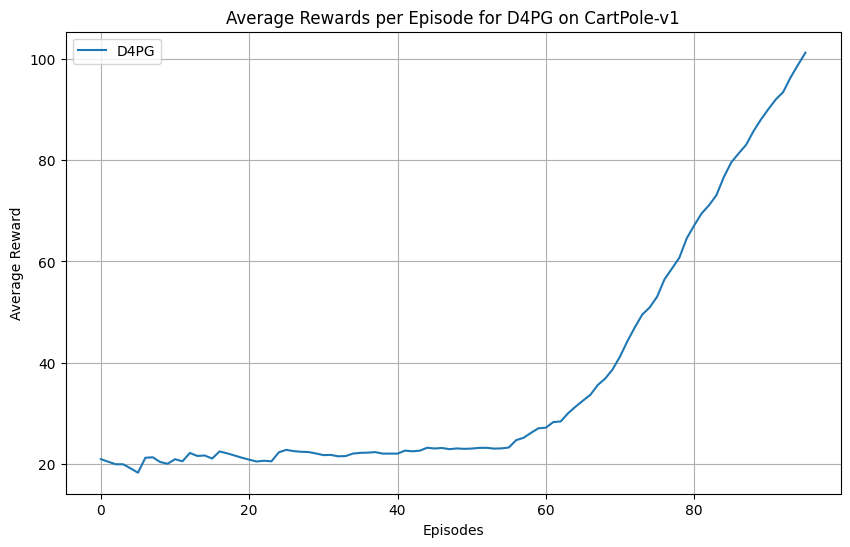

In [ ]:
if __name__ == "__main__":
    main()

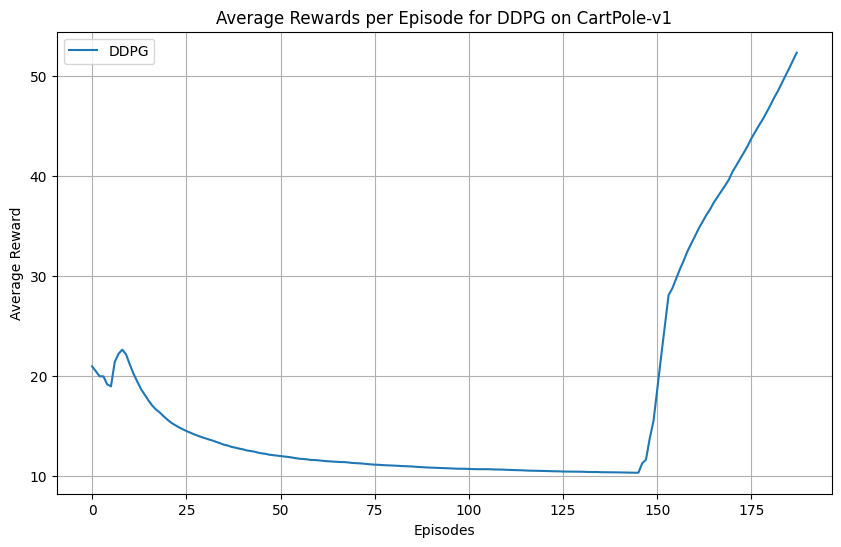

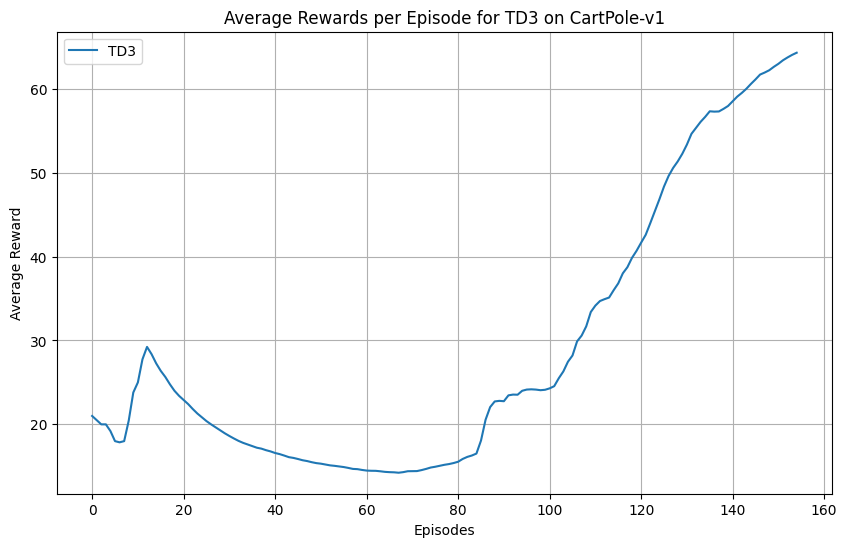

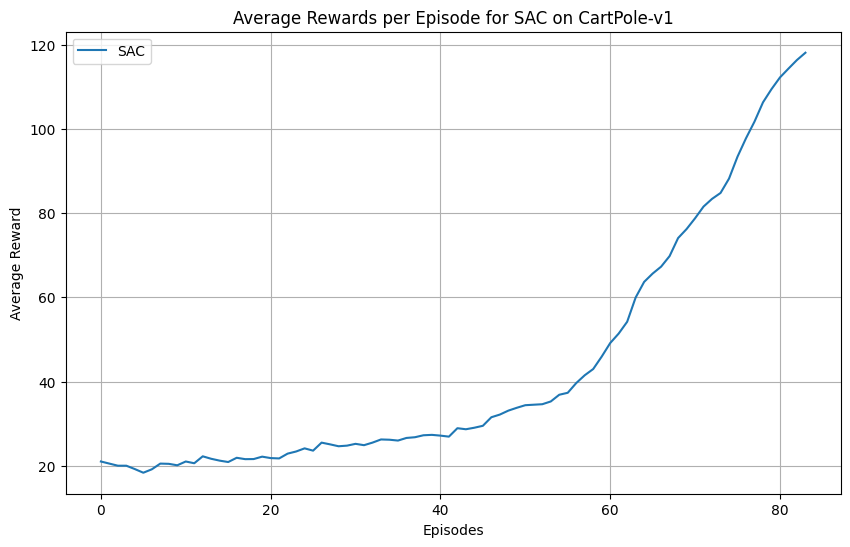

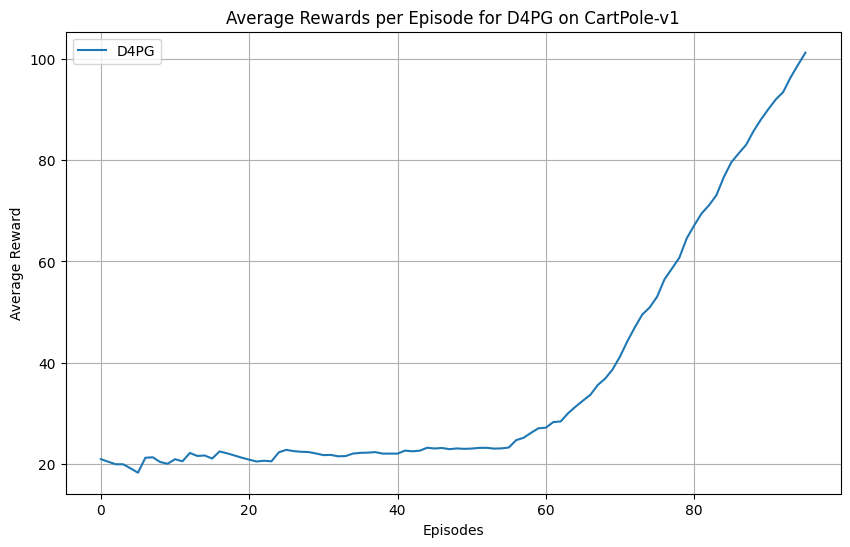

In [4]:
plot_average_rewards(os.path.join(SAVE_DIR, "average_rewards.pkl"))
